# import packages

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

from warnings import filterwarnings as fw
fw('ignore')

# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/01-WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib
#importlib.reload(sys.modules['inspection_plot'])

In [31]:
def plot_TSn2_profs(clm,std,tmp,ax,c1,c2,month=[],year=[],legend=False,fs=10,plot_ww_cd=False,lw=2):
    # plot temperature
    # climatology
    ax[0].plot(clm.ctemp,clm.z,color=c1,lw=lw)
    ax[0].fill_betweenx(clm.pres,clm.ctemp-std.ctemp,clm.ctemp+std.ctemp,alpha=0.25,color=c1)
    # april 2015 float
    ax[0].plot(tmp.ctemp.mean('n_prof'),tmp.z.mean('n_prof'),color=c2,lw=lw)
    ax[0].fill_betweenx(tmp.z.mean('n_prof'),(tmp.ctemp.mean('n_prof')-tmp.ctemp.std('n_prof')),
                        (tmp.ctemp.mean('n_prof')+tmp.ctemp.std('n_prof')),
                        alpha=0.25,color=c2)
    
    # plot asal
    # climatology
    ax[1].plot(clm.asal,clm.z,color=c1,lw=lw)
    ax[1].fill_betweenx(clm.pres,clm.asal-std.asal,clm.asal+std.asal,alpha=0.25,color=c1,lw=lw)
    # apr 2015 float
    ax[1].plot(tmp.asal.mean('n_prof'),tmp.z.mean('n_prof'),color=c2,lw=lw)
    ax[1].fill_betweenx(tmp.pres,(tmp.asal.mean('n_prof')-tmp.asal.std('n_prof')),
                        (tmp.asal.mean('n_prof')+tmp.asal.std('n_prof')),
                        alpha=0.25,color=c2)
    
    # plot n2
    # climatology
    ax[2].plot(clm.n2,clm.z,color=c1,label='clim',lw=lw)
    ax[2].fill_betweenx(clm.pres,clm.n2-std.n2,clm.n2+std.n2,alpha=0.25,color=c1,label='std')
    # apr 2015 float
    ax[2].plot(tmp.n2.mean('n_prof'),tmp.z.mean('n_prof'),color=c2,label=year,lw=lw)
    ax[2].fill_betweenx(tmp.z.mean('n_prof'),(tmp.n2.mean('n_prof')-tmp.n2.std('n_prof')),
                        (tmp.n2.mean('n_prof')+tmp.n2.std('n_prof')),
                        alpha=0.25,color=c2,label='std')

    if plot_ww_cd==True:
        for a in ax:
            a.axhline(y=clm.ww_cd,c=c1,ls='--')
            a.axhline(y=tmp.ww_cd.mean('n_prof'),c=c2,ls='--')
     #   a.axhline(y=clm.ww_cd,c=c1,ls='--',label='WW core')
      #  a.axhline(y=tmp.ww_cd.mean('n_prof'),c=c2,ls='--',label='WW core')
    
    ax[2].set_xticklabels([0,0,5,10])
    ax[2].set_xlabel(r'n2 x$10^{-5}$')
    
    ax[1].set_ylabel('')
    ax[2].set_ylabel('')
    
    for a in ax:
        a.invert_yaxis()
        a.set_title('')

    if legend==True:
        ax[-1].legend(loc=4,prop={'size': fs})

In [3]:
def data_feb_2021(ds):
    # feb 2021
    idx  = np.where(np.logical_and(ds.time.dt.month==2,ds.time.dt.year==2021))[0]
    tmp  = ds.isel(n_prof=idx).sel(pres=slice(10,400))
    # select profiles between 34-37, 55.5-57.5
    idx  = np.where(np.logical_and(tmp.lon<-34,tmp.lon>-37))[0]
    tmp  = tmp.isel(n_prof=idx)
    idx  = np.where(np.logical_and(tmp.lat<-55.5,tmp.lat>-57.5))[0]
    tmp  = tmp.isel(n_prof=idx)
    
    # import april climatology data:
    ds_grid = xr.open_dataset('data/SO_clim_F-0.5_deg-no_2004_2015_2021.nc')
    
    profs = ds_grid[['ctemp','asal','n2','z','ww_cd']].sel(lon=slice(-37,-34),lat=slice(-57.5,-55.5))
    clm = ds_grid[['ctemp','asal','n2','z','ww_cd']].sel(lon=slice(-37,-34),lat=slice(-57.5,-55.5)).mean(('lon','lat'))
    std = ds_grid[['ctemp','asal','n2','z','ww_cd']].sel(lon=slice(-37,-34),lat=slice(-57.5,-55.5)).std(('lon','lat'))

    return tmp,ds_grid,profs,clm,std

In [4]:
def data_apr_2015():
    # import april climatology data:
    ds_grid = xr.open_dataset('data/SO_april_clim-0.5_deg-no_2004_2015_2021.nc')
    
    profs = ds_grid[['ctemp','asal','n2','z','ww_cd']].sel(lon=slice(-35.5,-34.5),lat=slice(-54,-53))
    clm = ds_grid[['ctemp','asal','n2','z','ww_cd']].sel(lon=slice(-35.5,-34.5),lat=slice(-54,-53)).mean(('lon','lat'))
    std = ds_grid[['ctemp','asal','n2','z','ww_cd']].sel(lon=slice(-35.5,-34.5),lat=slice(-54,-53)).std(('lon','lat'))
    
    # apr 2015
    ds = xr.open_dataset('argo_6901972-vert_interp.nc') # open argo float datax
    ds['z'] = (gsw.z_from_p(ds.pres,ds.lat))*-1
    for i in range(ds.n_prof.size):
        ds['ww_cp'][i] = ds.ctemp[i].idxmin().data
    ds['ww_cd'] = (gsw.z_from_p(ds.ww_cp,ds.lat))*-1
    idx  = np.where(np.logical_and(ds.time.dt.month==4,ds.time.dt.year==2015))[0]
    tmp  = ds.isel(n_prof=idx).sel(pres=slice(10,400))
    tmp  = tmp.isel(n_prof=[1,2])
    return ds_grid,profs,clm,std,tmp

# load data

In [6]:
#ds = xr.open_dataset('data/SO_1yr_clim_seasonal-0.5_deg_v2.nc').rename({'time':'season'})

In [5]:
ds = xr.open_dataset('data/SO_JFMA_clim-ww_n2-0.5_deg-no_2004_2015_2021.nc')

In [6]:
ds1 = xr.open_dataset('/home/theospira/notebooks/projects/01-WW_climatology/data/hydrographic_profiles/superseded/ww_gauss_smoothed_ds-preDec23.nc')

# make ds that contains only WW profiles 
#ds_ww = ds.isel(n_prof=np.where(ds.ww_type.notnull())[0]) 

for i,d in enumerate(np.unique(ds1.dsource)):
    idx = np.where(ds1.dsource == d)[0]
    ds1['dsource'][idx] = i+1

ds1.dsource.attrs['description'] = "'Argo':1, 'CTD':2, 'Gliders':3, 'MEOP':4, 'SOCCOM':5"
ds1['dsource'] = ds1['dsource'].astype(int)

# calculate pressure variables as depth
arr = []
lat = ds1.lat.data
for v in ['ww_cp','up_bd','lw_bd']:
    arr += gsw.z_from_p(ds1[v],lat),

ds1['ww_cd'] = xr.DataArray(arr[0].copy()*-1)
ds1['up_bd'] = xr.DataArray(arr[1].copy()*-1)
ds1['lw_bd'] = xr.DataArray(arr[2].copy()*-1)

# calculate z across dataset
p = np.ndarray(ds1.ctemp.shape)*np.nan
l = np.ndarray(ds1.ctemp.shape)*np.nan

lat  = ds1.lat.data
pres = ds1.pres.data
for i in range(p.shape[0]):
    p[i,:] = pres
for i in range(l.shape[1]):
    l[:,i] = lat

ds1['z'] = xr.DataArray(gsw.z_from_p(p,l)*-1,dims=ds1.ctemp.dims)

# plot

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as ss
from plot_formatting import *
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

In [8]:
def set_ax_boundaries(ax,xmin,xmax,ymin,ymax,n=20):
    aoi = mpath.Path(
    list(zip(np.linspace(xmin,xmax, n), np.full(n,ymax))) + \
    list(zip(np.full(n,xmax), np.linspace(ymax,ymin, n))) + \
    list(zip(np.linspace(xmax,xmin, n), np.full(n,ymin))) + \
    list(zip(np.full(n,xmin), np.linspace(ymin,ymax, n)))
    )
    ax.set_boundary(aoi, transform=ccrs.PlateCarree())

In [27]:
sns.set(#font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
ratio = 7/12.5
mpl.rcParams["figure.titlesize"] = 25 * ratio
mpl.rcParams["axes.titlesize"] = 20 * ratio
mpl.rcParams["axes.labelsize"] = 15 * ratio
mpl.rcParams["font.size"] = 12 * ratio
mpl.rcParams["xtick.labelsize"] = 12 * ratio
mpl.rcParams["ytick.labelsize"] = 12 * ratio
mpl.rcParams["ytick.labelright"] = False

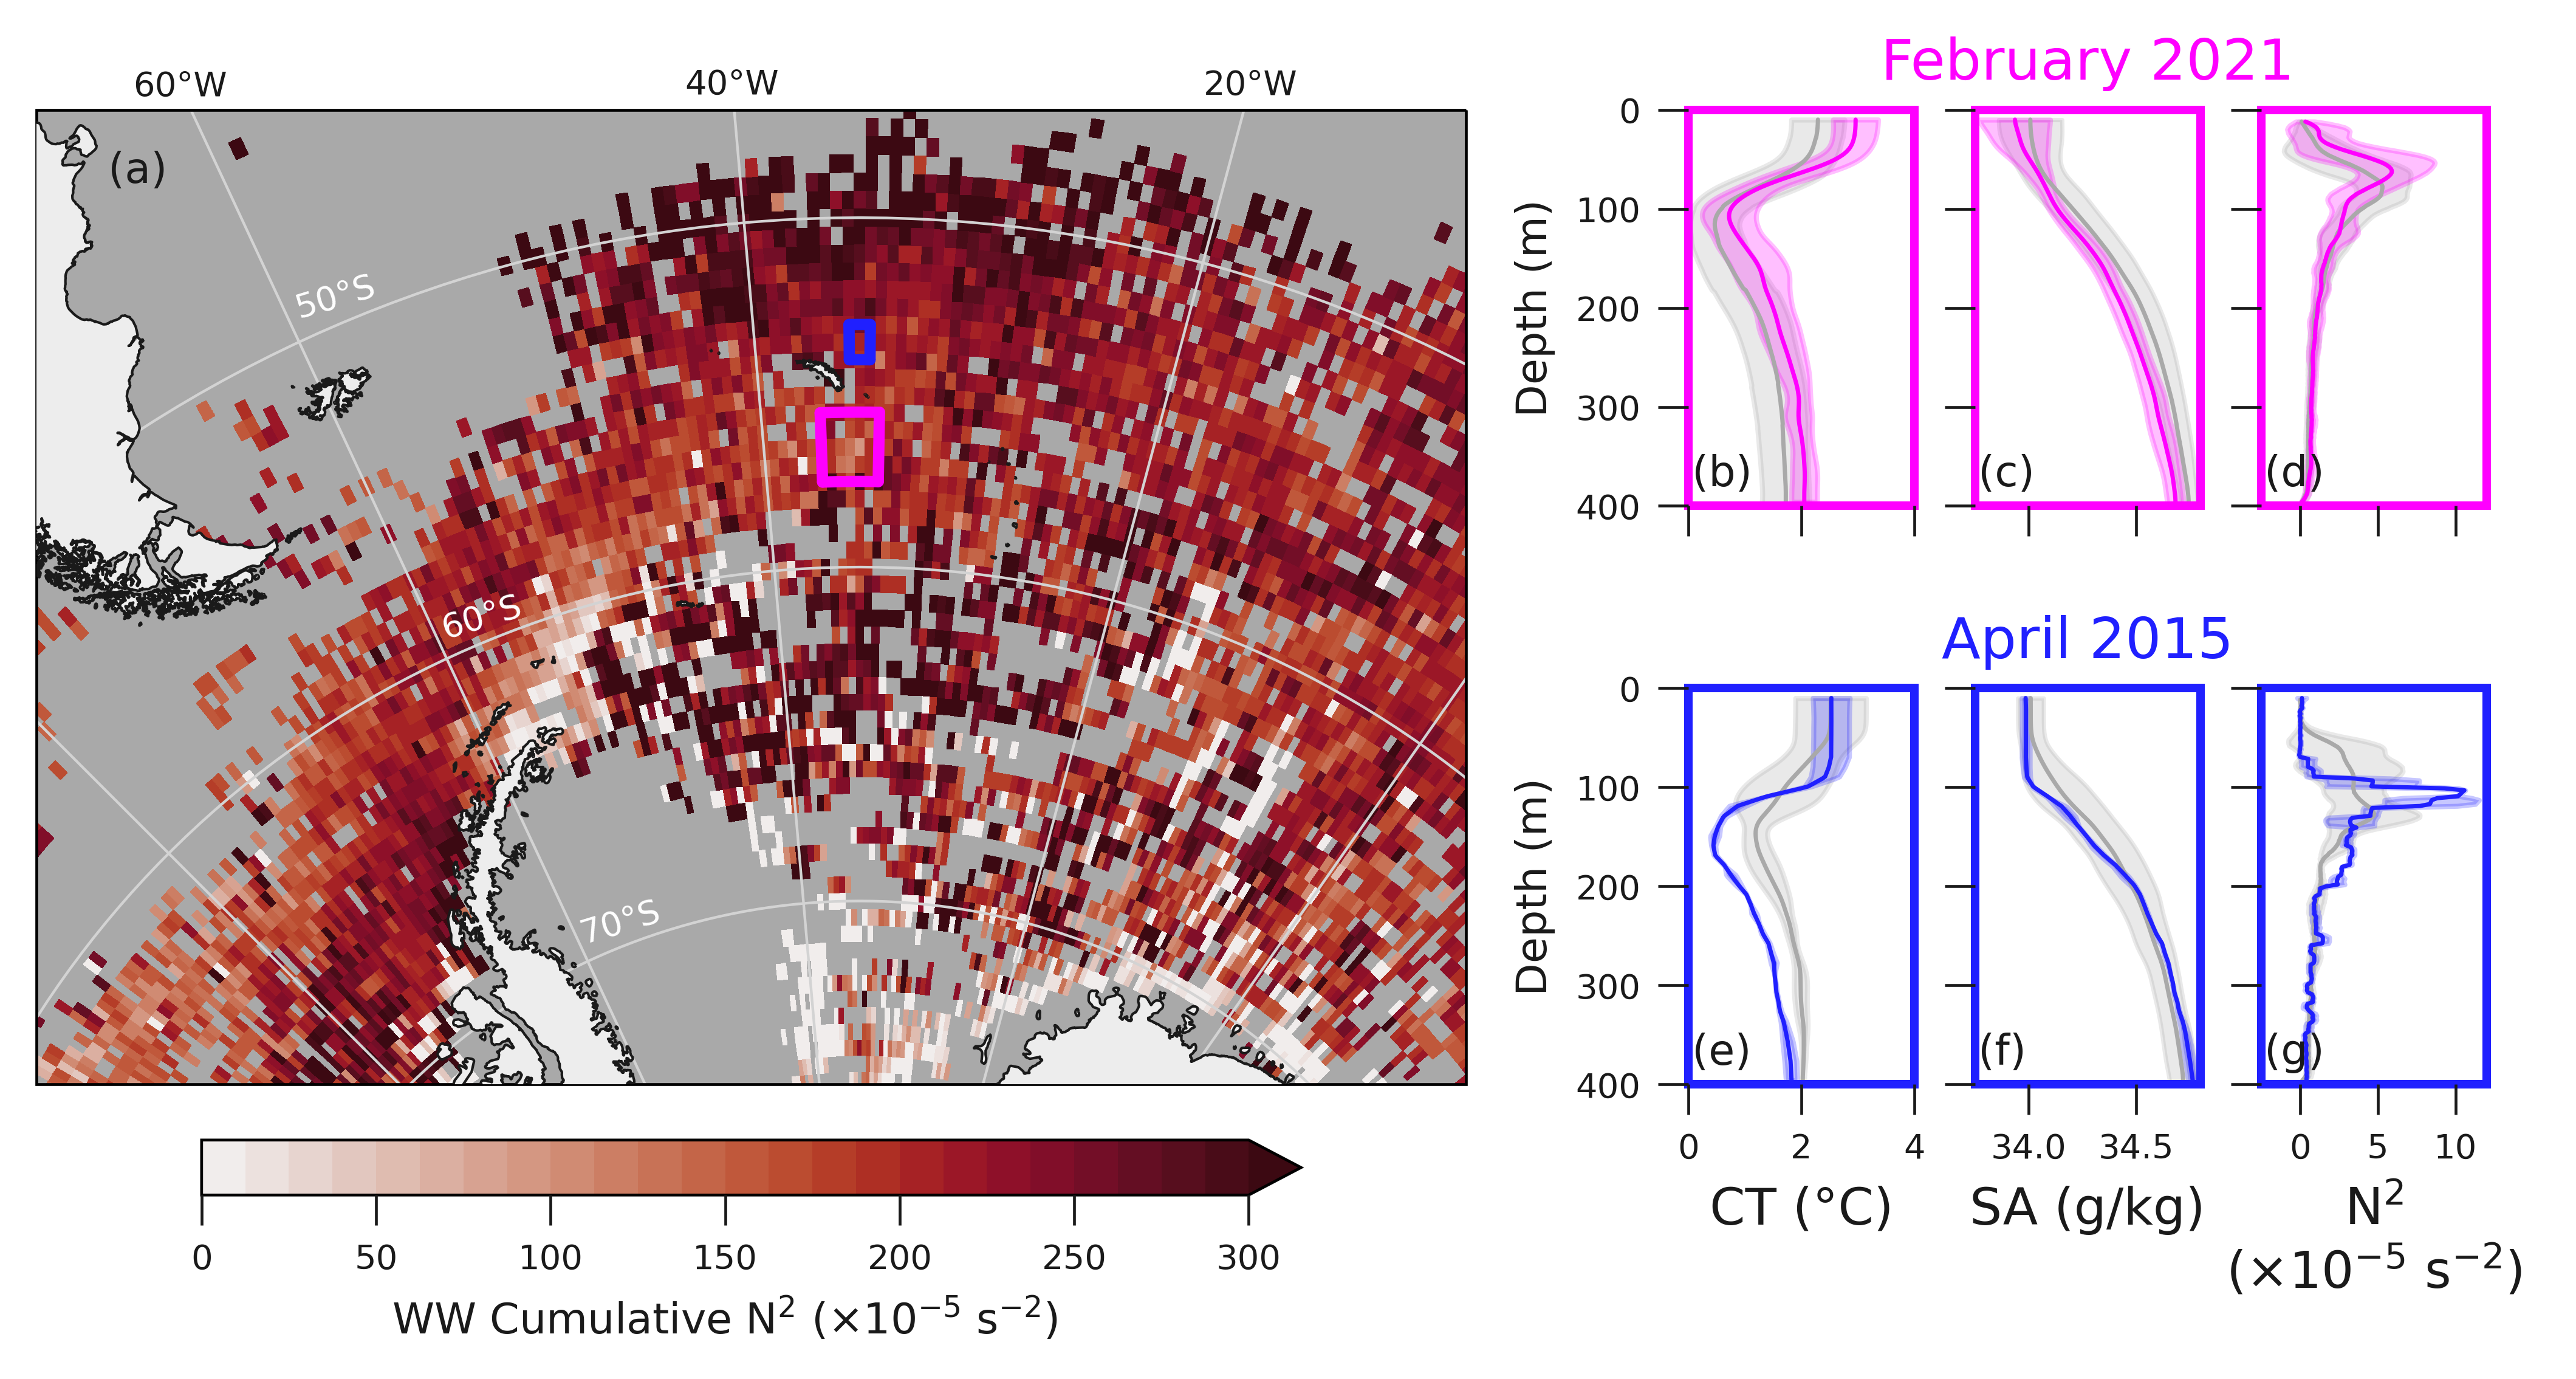

In [51]:
c1 = '#ff00ff' # '#377eb8'   # feb 2021 colour
c2 = '#2020ff' # '#0000ff'   # '#4daf4a' # apr 2015 colour

alphbt = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 
              'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

fig = plt.figure(figsize=(7, 3.92), constrained_layout=True, dpi=600)
gs  = gridspec.GridSpec(2, 5, figure=fig, width_ratios=[6.5, 1., 1., 1., 0.1], height_ratios=[1, 0.1])
crs = ccrs.PlateCarree()

# Create subplots for the first row (excluding the colorbar space)
ax = []

# create map
ax.append(fig.add_subplot(gs[0, 0],projection=ccrs.SouthPolarStereo(central_longitude=-35),))

#ax[0].set_extent([-50,-20,-82,-47],crs=crs) # for SP stereo
ax[0].set_extent([-70,-10,-72.5,-47],crs=crs) # for SP stereo
ax[0].add_feature(cfeature.LAND,zorder=9,facecolor="#ededed",)
ax[0].coastlines(zorder=10,color="k",resolution='10m',lw=0.5) # shows continental coastline
ax[0].set_facecolor('darkgrey',)

#n2 = (ds.ww_n2[2]*1e5).plot(ax=ax[0],x='lon',transform=crs,cmap='cmo.amp',
n2 = (ds.ww_n2*1e5).plot(ax=ax[0],x='lon',transform=crs,cmap='cmo.amp',zorder=2,
                         vmin=0,vmax=300,levels=int(300/12.5+1),
                         cbar_kwargs={'location':'bottom','shrink':0.75,
                        'label':r'WW Cumulative N$^2$ ($\times 10^{-5}$ s$^{-2}$)'})
n2.colorbar.ax.set_xticks(np.arange(0,350,50))
n2.colorbar.ax.minorticks_off()

ax[0].set_title('')

gl = ax[0].gridlines(color='lightgrey',lw=0.75*(ratio*1.25))
gl.xlabels_top = True
gl.xlabel_style = {'rotation': 0, 'ha':'center'}
gl.ylocator = mticker.FixedLocator([-70, -60, -50])  # Set the latitude values for labeling

for i in [70, 60, 50]:
    ax[0].text(x=-60+0.5,y=-1*i+1.2,s=str(i)+"°S",transform=crs,c='w',rotation=17,va='center')
#ax[0].annotate('South Georgia', xy=(-38, -54), xytext=(-58,-45.5), transform=crs, fontsize=15,
 #              arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2",color='w',lw=1.5))
#ax[0].text(x=0.67,y=0.02,s="Antarctica",transform=ax[0].transAxes,fontsize=15,zorder=15)


# add boxes for regions of interest
plot_nice_box(ax[0],x1=-37,x2=-34,y1=-57.5,y2=-55.5,c=c1,lw=4*ratio) # feb 21
plot_nice_box(ax[0],x1=-35.5,x2=-34.5,y1=-54,y2=-53,c=c2,lw=4*ratio) # apr 15

# create profile subplots
for i in range(3):
    ax.append(fig.add_subplot(gs[0, 1+i]))
    ax.append(make_axes_locatable(ax[-1]).append_axes("bottom", size="100%", pad=0.5)) 

# T,S,N2 plots
tmp,ds_grid,profs,clm,std = data_feb_2021(ds1)
plot_TSn2_profs(clm,std,tmp,ax[1::2],c1='darkgrey',c2=c1,legend=False,month='',year="2021",lw=1.5*ratio)
ds_grid,profs,clm,std,tmp = data_apr_2015()
plot_TSn2_profs(clm,std,tmp,ax[2::2],c1='darkgrey',c2=c2,legend=False,month='',year="2015",lw=1.5*ratio)

# formatting
fs = 18 * ratio
for a in ax[1:3]:
    a.set_xlim(0,4)
    a.set_xticks([0,2,4])
    a.set_xlabel('')
a.set_xlabel('CT (°C)',fontsize=fs)

for a in ax[3:5]:
    a.set_xlim(33.75,34.8)
    #a.set_xticks([0,2,4])
    a.set_xlabel('')
a.set_xlabel('SA (g/kg)',fontsize=fs)

for a in ax[5:]:
    a.set_xlim(-2.5e-5,12e-5)
    a.set_xticks([0,5e-5,10e-5])
    a.set_xticklabels([0,5,10])
    a.set_xlabel('')
a.set_xlabel(r'N$^2$''\n'r'($\times 10^{-5}$ s$^{-2}$)',fontsize=fs)

for a in ax[1::2]:
    a.set_xticklabels([])
for a in ax[3:]:
    a.set_yticklabels([])
for a in ax[1:3]:
    a.set_ylabel('Depth (m)',fontsize=fs-3*ratio)

# annotation
ax[0].text(x=0.05,y=0.925,s="(a)",transform=ax[0].transAxes,fontsize=15*ratio,)
for i,a in enumerate(ax[1::2]):
    a.text(x=0.015,y=.05,s="("+alphbt[i+1]+")",transform=a.transAxes,fontsize=15*ratio,)
    a.set_ylim(400,0)
for i,a in enumerate(ax[2::2]):
    a.text(x=0.015,y=.05,s="("+alphbt[i+4]+")",transform=a.transAxes,fontsize=15*ratio,)
    a.set_ylim(400,0)

ax[3].set_title('February 2021',fontsize=20*ratio,c=c1)
for a in ax[1::2]:
    plt.setp(a.spines.values(), color=c1,linewidth=3*ratio)
    a.xaxis.set_tick_params(width=1*ratio)
    a.yaxis.set_tick_params(width=1*ratio)
ax[4].set_title('April 2015',fontsize=20*ratio,c=c2)
for a in ax[2::2]:
    plt.setp(a.spines.values(), color=c2,linewidth=3*ratio)
    a.xaxis.set_tick_params(width=1*ratio)
    a.yaxis.set_tick_params(width=1*ratio)

a=ax[0]
plt.setp(a.spines.values(),linewidth=1*ratio)
plt.setp(n2.colorbar.ax.spines.values(),linewidth=1*ratio)
n2.colorbar.ax.xaxis.set_tick_params(width=1*ratio)


#fig.show()

# add blank fig to the end 
ax.append(fig.add_subplot(gs[0, 4]))
# Set the background color to white
ax[-1].set_facecolor('white')
# Hide the spines
ax[-1].spines['top'].set_visible(False)
ax[-1].spines['right'].set_visible(False)
ax[-1].spines['bottom'].set_visible(False)
ax[-1].spines['left'].set_visible(False)
ax[-1].tick_params(axis='both', which='both', bottom=False, top=False, left=False,
                right=False, labelbottom=False, labelleft=False)
#fig.show()

#fig.savefig('SO_WW_n2-and-tsn2_profiles.pdf',format='pdf',) # bbox_inches = 'tight')

# check what data are in the boxes

In [104]:
def flatten_list(matrix):
    return [item for row in matrix for item in row]

## feb 21 data

In [101]:
idx  = np.where(np.logical_and(ds1.time.dt.month==2,ds1.time.dt.year==2021))[0]
tmp  = ds1.isel(n_prof=idx).sel(pres=slice(10,400))
# select profiles between 34-37, 55.5-57.5
idx  = np.where(np.logical_and(tmp.lon<-34,tmp.lon>-37))[0]
tmp  = tmp.isel(n_prof=idx)
idx  = np.where(np.logical_and(tmp.lat<-55.5,tmp.lat>-57.5))[0]
tmp  = tmp.isel(n_prof=idx)

In [113]:
ds_ww = ds1.isel(n_prof=np.where(ds1.ww_type.notnull())[0]) 

idx = []
for i in [2004,2015,2021]:
    idx += np.where(ds_ww.time.dt.year==i)[0],
idx = flatten_list(idx)

tmp = ds_ww.drop_isel(n_prof=idx)

In [116]:
tmp = ds_ww.isel(n_prof=np.where(ds_ww.time.dt.month==2)[0])
# select profiles between 34-37, 55.5-57.5
idx  = np.where(np.logical_and(tmp.lon<-34,tmp.lon>-37))[0]
tmp  = tmp.isel(n_prof=idx)
idx  = np.where(np.logical_and(tmp.lat<-55.5,tmp.lat>-57.5))[0]
tmp  = tmp.isel(n_prof=idx)

In [134]:
tmp.dsource.count().data

array(70)

In [132]:
for i in range(1,6,1):
    print(i,(tmp.dsource==i).sum().data)

1 27
2 16
3 0
4 27
5 0


In [137]:
tmp.dsource.attrs

{'description': "'Argo':1, 'CTD':2, 'Gliders':3, 'MEOP':4, 'SOCCOM':5"}

## apr 2015 data

In [138]:
ds_ww = ds1.isel(n_prof=np.where(ds1.ww_type.notnull())[0]) 

idx = []
for i in [2004,2015,2021]:
    idx += np.where(ds_ww.time.dt.year==i)[0],
idx = flatten_list(idx)

tmp = ds_ww.drop_isel(n_prof=idx)

In [139]:
tmp = ds_ww.isel(n_prof=np.where(ds_ww.time.dt.month==4)[0])
# select profiles between 34-37, 55.5-57.5
idx  = np.where(np.logical_and(tmp.lon<-34.5,tmp.lon>-35.5))[0]
tmp  = tmp.isel(n_prof=idx)
idx  = np.where(np.logical_and(tmp.lat<-53,tmp.lat>-54))[0]
tmp  = tmp.isel(n_prof=idx)

In [140]:
tmp.dsource.count().data

array(7)

In [141]:
for i in range(1,6,1):
    print(i,(tmp.dsource==i).sum().data)

1 7
2 0
3 0
4 0
5 0


In [137]:
tmp.dsource.attrs

{'description': "'Argo':1, 'CTD':2, 'Gliders':3, 'MEOP':4, 'SOCCOM':5"}